In [ ]:
!wget https://hf.co/danjacobellis/walloc/resolve/main/RGB_Li_27c_J3_nf4_v1.0.2.pth

In [1]:
import torch
import torch.nn as nn
import numpy as np
import warnings
import IPython.display
import io
from PIL import Image
from einops import rearrange
from datasets import load_dataset
from torchvision.transforms import (
    RandomResizedCrop, Resize, Grayscale,
    PILToTensor, ToPILImage, 
    Compose, RandomHorizontalFlip )
from DenseViT import DenseViT
from fastprogress.fastprogress import master_bar, progress_bar
from walloc import walloc
class Config: pass

In [2]:
device = "cuda:6"

checkpoint = torch.load("RGB_Li_27c_J3_nf4_v1.0.2.pth",map_location="cpu",weights_only=False)
codec_config = checkpoint['config']
codec = walloc.Codec2D(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits,
    lightweight_encode = codec_config.lightweight_encode
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec = codec.to(device)
codec.eval();

In [3]:
config = Config()
# Training and optimizer config
config.batch_size = 128
config.grad_accum_steps = 1
config.min_lr = 1e-6
config.max_lr = 1e-4 
config.warmup_steps = 10000
config.plot_update = 128
config.patience = 128
config.weight_decay = 0.
config.epochs = 30
config.num_workers = 24
config.valid_samples_per_epoch = 256

# Colorization model config
config.image_size = 128
config.channels = 3
config.patch_size = 8
config.num_classes = 27
config.embed_dim = 192
config.depth = 12
config.heads = 3
config.mlp_dim = 768
config.dim_head = config.embed_dim//config.heads

In [4]:
model = DenseViT(
    image_size = config.image_size//(2**codec_config.J),
    channels = codec_config.latent_dim,
    patch_size = config.patch_size//(2**codec_config.J),
    num_classes = config.num_classes,
    dim = config.embed_dim,
    depth = config.depth,
    heads = config.heads,
    mlp_dim = config.mlp_dim,
    dim_head = config.dim_head
).to(device)
sum(p.numel() for p in model.parameters())/1e6

5.341329

In [5]:
dataset_train = load_dataset('imagenet-1k',split='train',trust_remote_code=True)
dataset_valid = load_dataset('imagenet-1k',split='validation',trust_remote_code=True)

Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

In [6]:
L = config.image_size
C = config.channels

train_transform = Compose([
    RandomResizedCrop(
        size=(L,L),
        scale=(0.5, 1),
        interpolation=Image.Resampling.LANCZOS
    ),
    RandomHorizontalFlip(0.5),
    PILToTensor()
])

valid_transform = Compose([
    Resize(
        size=(L,L),
        interpolation=Image.Resampling.LANCZOS
    ),
    PILToTensor(),
])

def train_collate_fn(batch):
    B = len(batch)    
    x = torch.zeros( (B, C, L, L), dtype=torch.uint8)
    y = torch.zeros( (B, C, L, L), dtype=torch.uint8)

    for i_sample, sample in enumerate(batch):
        img = sample['image'].convert("RGB")
        y[i_sample,:,:,:] = train_transform(img)
        x[i_sample,:,:,:] = Grayscale(num_output_channels=3)(y[i_sample,:,:,:])
    return x, y

def valid_collate_fn(batch):
    B = len(batch)    
    x = torch.zeros( (B, C, L, L), dtype=torch.uint8)
    y = []
    for i_sample, sample in enumerate(batch):
        img = sample['image'].convert("RGB")
        x[i_sample,:,:,:] = Grayscale(num_output_channels=3)(valid_transform(img))
        y.append(img)
    return x, y

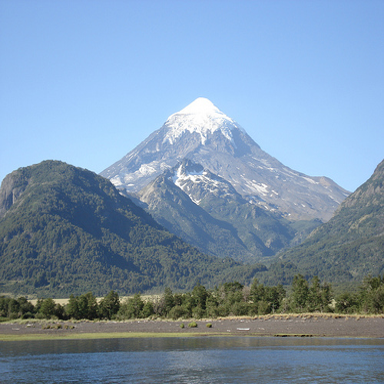

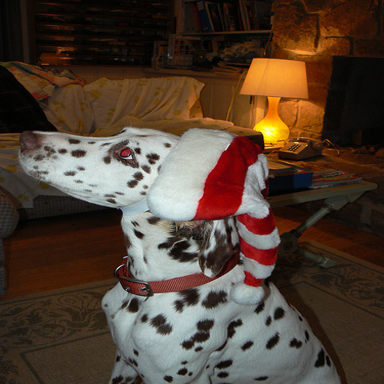

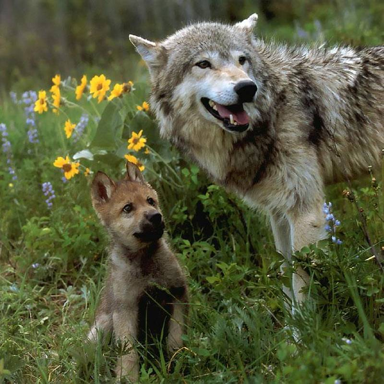

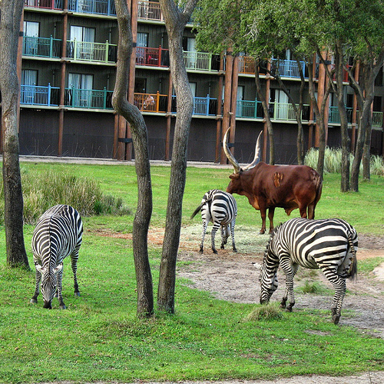

In [7]:
 display_samples = torch.utils.data.DataLoader(
    dataset_valid.select([2,36,46,83]),
    batch_size=4,
    num_workers=12,
    drop_last=True,
    shuffle=False,
    collate_fn=valid_collate_fn
)
valid_x, valid_y = next(iter(display_samples))
valid_x = valid_x.to(torch.float)
valid_x = valid_x / 255
valid_x = valid_x - 0.5
valid_x = valid_x.to(device)
valid_x = codec.wavelet_analysis(valid_x, codec.J)
valid_x = codec.encoder[:2](valid_x)
for vy in valid_y:
    display(vy.resize((384,384)))

In [8]:
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=config.min_lr,
    weight_decay=config.weight_decay
)

def minus_cosine_warmup(i_step):
    scale = 0.5 * (np.log10(config.max_lr) - np.log10(config.min_lr))
    angle =  np.pi * i_step / (config.warmup_steps//config.plot_update)
    log_lr = np.log10(config.min_lr) + scale * (1 - np.cos(angle))
    lr = 10 ** log_lr
    return lr/config.min_lr
    
warmup = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: minus_cosine_warmup(i_step)
)

reduce_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.98,
    patience=config.patience,
    threshold=1e-3,
    min_lr=config.min_lr
)

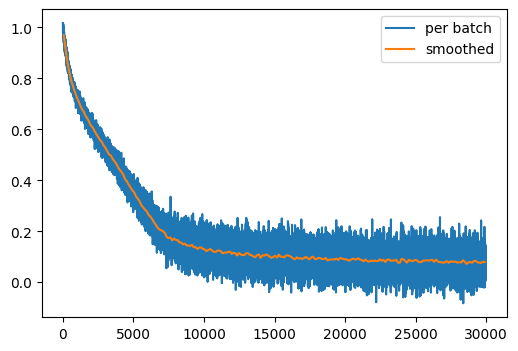

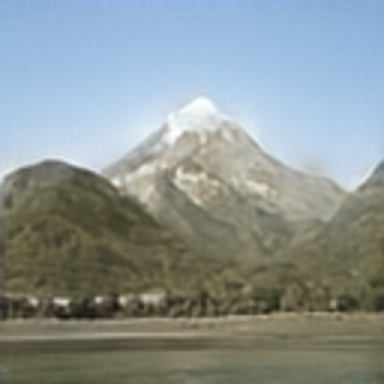

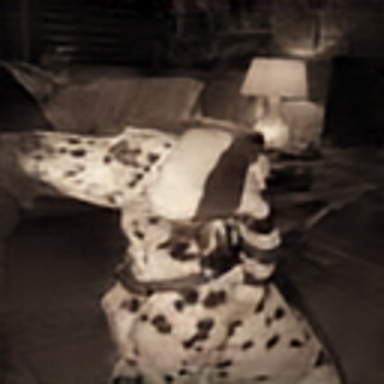

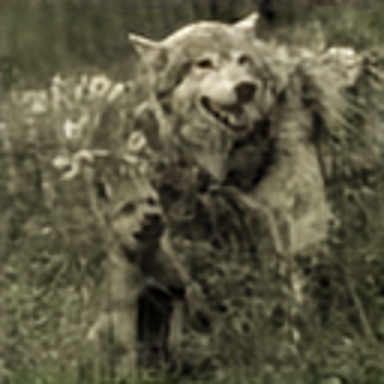

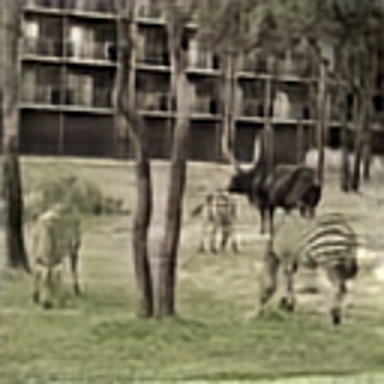

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
warnings.filterwarnings("ignore", message="Corrupt EXIF data.  Expecting to read .* bytes but only got .*", category=UserWarning, module="PIL.TiffImagePlugin")
warnings.filterwarnings("ignore", message="Metadata Warning, tag .* had too many entries: .* expected .*", category=UserWarning, module="PIL.TiffImagePlugin")
warnings.filterwarnings("ignore", message="Truncated File Read", category=UserWarning, module="PIL.TiffImagePlugin")

mb = master_bar(range(config.epochs))
mb.names = ['per batch','smoothed']
img_displays = []
train_loss = []
valid_loss = []
learning_rates = [optimizer.param_groups[0]['lr']]

i_step = 0
for i_epoch in mb:
    # training
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=train_collate_fn
    )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, (x,y) in enumerate(pb):
        x = x.to(torch.float)
        y = y.to(torch.float)
        x = x / 255
        y = y / 255
        x = x - 0.5
        y = y - 0.5
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            x = codec.wavelet_analysis(x,codec.J)
            y = codec.wavelet_analysis(y,codec.J)
            x = codec.encoder[:2](x)
            y = codec.encoder[:2](y)            
        
        pred = model(x)
        loss = nn.functional.mse_loss(pred, y)
        train_loss.append(loss.item())
        loss.backward()
        if (i_batch + 1) % config.grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # plotting
        if len(train_loss) % config.plot_update == 0:
            plot_n = len(train_loss) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(train_loss).reshape(plot_n, -1).mean(dim=1)
            train_x = range(len(train_loss))
            train_y = train_loss
            mb.update_graph([[train_x, np.log10(train_y)],[smoothed_x, np.log10(smoothed_y)]])

            # lr scheduler
            if i_step < config.warmup_steps:
                warmup.step()
            else:
                reduce_plateau.step(smoothed_y[-1])
            learning_rates.append(optimizer.param_groups[0]['lr'])
            
            mb.child.comment = f'loss {smoothed_y[-1]:.4g}; lr {learning_rates[-1]:.4g}'

            # Display selected images
            model.eval()
            with torch.no_grad():
                pred = model(valid_x)
                pred = codec.decoder(pred)
                pred = codec.wavelet_synthesis(pred, codec.J)
                pred = codec.clamp(pred) + 0.5
            model.train()
            for img_idx, img in enumerate(pred):
                buffer = io.BytesIO()
                ToPILImage()(img).resize((384,384)).save(buffer, format="PNG")
                buffer.seek(0)
                if len(img_displays) <= img_idx:
                    img_displays.append(display(IPython.display.Image(buffer.read()), display_id=True))
                else:
                    IPython.display.update_display(IPython.display.Image(buffer.read()), display_id=img_displays[img_idx].display_id)

        i_step+=1
        
    # validation
    model.eval()
    valid_loss.append(0)
    rand_sample = torch.randint(low=0, high=dataset_valid.num_rows,size=(config.valid_samples_per_epoch,))
    data_loader_valid = torch.utils.data.DataLoader(
        dataset_valid.select(rand_sample),
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    pb_valid = progress_bar(data_loader_valid, parent=mb)
    valid_loss_per_sample = []
    for i_batch, (x,y) in enumerate(pb_valid):
        x = x.to(torch.float)
        x = x / 255
        x = x - 0.5
        x = x.to(device)
        with torch.no_grad():
            x = codec.wavelet_analysis(x, codec.J)
            x = codec.encoder[:2](x)
            pred = model(x)
            pred = codec.decoder(pred)
            pred = codec.wavelet_synthesis(pred, codec.J)
            pred = codec.clamp(pred) + 0.5
            for i_valid, yi in enumerate(y):
                pred_i = Resize(size=(yi.height, yi.width))(pred[i_valid])
                yi = PILToTensor()(yi)
                yi = yi.to(torch.float)
                yi = yi / 255
                yi = yi.to(device)
                loss = nn.functional.mse_loss(pred_i, yi)
                valid_loss_per_sample.append(loss.item())
    valid_loss[-1] = np.median(valid_loss_per_sample)
    mb.main_bar.comment = f'valid_loss {valid_loss[-1]:.4g}'
    mb.child.comment = f'loss {smoothed_y[-1]:.4g}; lr {learning_rates[-1]:.4g}'

    torch.save({
        'i_epoch': i_epoch,
        'model_state_dict': model.state_dict(),
        'learning_rates': learning_rates,
        'smoothed_y': smoothed_y,
        'valid_loss': valid_loss,
        'config': config,
        'model_state_dict': model.state_dict(),
    }, f"log_{device}.pth")

In [10]:
from IPython.display import display, Image, update_display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

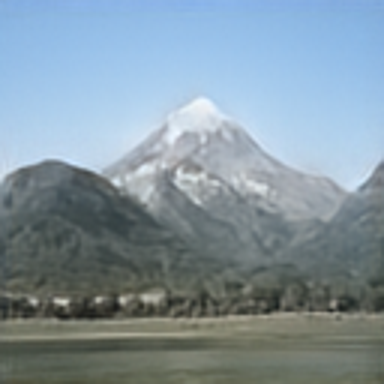

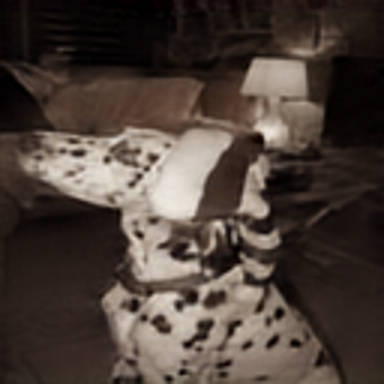

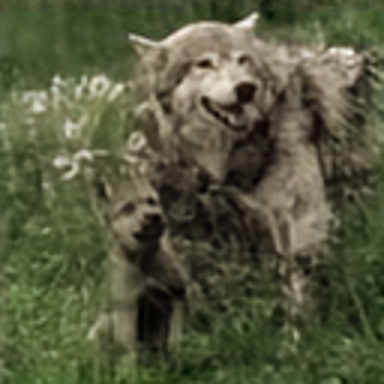

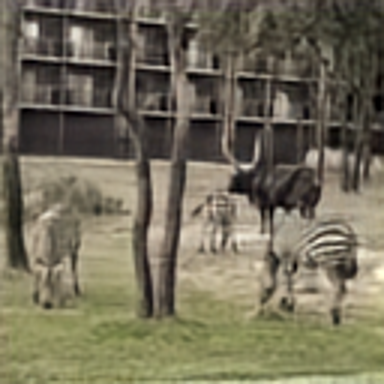

In [11]:
model.eval()
with torch.no_grad():
    pred = model(valid_x)
    pred = codec.decoder(pred)
    pred = codec.wavelet_synthesis(pred, codec.J)
    pred = codec.clamp(pred) + 0.5
    for img_idx, img in enumerate(pred):
        display(ToPILImage()(img).resize((384,384)))

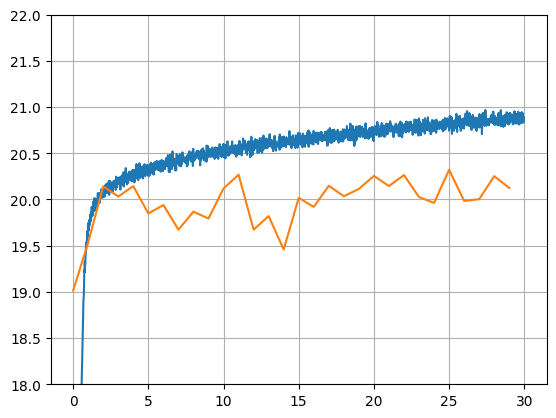

In [12]:
plt.plot(128*smoothed_x/dataset_train.num_rows,-10*np.log10(8e-3*smoothed_y))
plt.plot(-10*np.log10(valid_loss))
plt.ylim([18,22]);
plt.grid()

In [13]:
data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    drop_last=False,
    pin_memory=True,
    collate_fn=valid_collate_fn
)
pb_valid = progress_bar(data_loader_valid)
valid_loss_per_sample = []
for i_batch, (x,y) in enumerate(pb_valid):
        x = x.to(torch.float)
        x = x / 255
        x = x - 0.5
        x = x.to(device)
        with torch.no_grad():
            x = codec.wavelet_analysis(x, codec.J)
            x = codec.encoder[:2](x)
            pred = model(x)
            pred = codec.decoder(pred)
            pred = codec.wavelet_synthesis(pred, codec.J)
            pred = codec.clamp(pred) + 0.5
            for i_valid, yi in enumerate(y):
                pred_i = Resize(size=(yi.height, yi.width))(pred[i_valid])
                yi = PILToTensor()(yi)
                yi = yi.to(torch.float)
                yi = yi / 255
                yi = yi.to(device)
                loss = nn.functional.mse_loss(pred_i, yi)
                valid_loss_per_sample.append(loss.item())
valid_loss[-1] = np.median(valid_loss_per_sample)

In [14]:
-10*np.log10(valid_loss[-1])

20.12386919633917

In [15]:
torch.save({
    'i_epoch': i_epoch,
    'model_state_dict': model.state_dict(),
    'learning_rates': learning_rates,
    'smoothed_y': smoothed_y,
    'valid_loss': valid_loss,
    'config': config,
}, f"checkpoints/colorize_walloc_128.pth")